In [4]:
import sys
import rpy2
sys.version

'2.7.12 |Anaconda 4.1.1 (64-bit)| (default, Jul  2 2016, 17:42:40) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [90]:
import warnings

import readline
import rpy2.robjects

warnings.filterwarnings('ignore')

%load_ext rpy2.ipython

%run ../notebook-init.py

# load R libraries                                                                                    
%R invisible(library(ggplot2))
%R invisible(library(fastcluster))
%R invisible(library(reshape))
%R invisible(library(reshape2))
%R invisible(library(gplots))
%R invisible(library(RSQLite))

#set up ggplot2 defaults                                                                              
%R theme_set(theme_gray(base_size=18))

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Populating the interactive namespace from numpy and matplotlib


In [5]:
ls

FMT Crohn's.ipynb  Gene Prevalence Model.ipynb


In [91]:
import numpy as np
import pandas as pd
from glob import glob

sbres = glob('../shortbred/FMTchrons2/*results.txt')
print(sbres)
tbls = {}
for fname in sbres:
    tbl = pd.read_table(fname,header=0,index_col=0)
    tblname = fname.split('/')[-1]
    tblname = tblname.split('.')[0]
    rep = tblname.split('-')[2]
    time = tblname.split('-')[1]
    if time.lower() == 'pre_fmt':
        time = 0
    elif '4' in time:
        time = 4
    elif '8' in time:
        time = 8
        
    if rep not in tbls:
        tbls[rep] = {}
    tbls[rep][time] = tbl[['Count']]
    
    
subtbls={}

for rep, tblset in tbls.items():
        subtbls[rep] = pd.concat(tblset,axis=1)



pnl = pd.Panel(subtbls)




['../shortbred/FMTchrons2/cd-8-R1011.sb_results.txt', '../shortbred/FMTchrons2/cd-8-R1015.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1003.sb_results.txt', '../shortbred/FMTchrons2/cd-pre_FMT-R1004.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1017.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1002.sb_results.txt', '../shortbred/FMTchrons2/cd-pre_FMT-R1021.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1004.sb_results.txt', '../shortbred/FMTchrons2/cd-8-R1001.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1005.sb_results.txt', '../shortbred/FMTchrons2/cd-8-R1007.sb_results.txt', '../shortbred/FMTchrons2/cd-pre_FMT-R1014.sb_results.txt', '../shortbred/FMTchrons2/cd-8-R1012.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1006.sb_results.txt', '../shortbred/FMTchrons2/cd-8-R1021.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1001.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1021.sb_results.txt', '../shortbred/FMTchrons2/cd-4-R1020.sb_results.txt', '../shortbred/FMTchrons2/cd

In [92]:

rs = {}

for key in pnl.items:
    rep = pnl[key]
    skip = isnan(rep).any().any()
    if skip:
        continue
    rs[key] = {
                'zero-to-high':0,
                'low-to-high':0,
                'high-to-zero':0,
                'high-to-low':0,
            }

    for row in rep.iterrows():
        row = [r[1] for r in row[1].iteritems()]
            
        if row[0] == 0 and row[1] > 0:
            rs[key]['zero-to-high'] += 1
        elif row[0] < row[1]:
            rs[key]['low-to-high'] += 1
        elif row[0] > 0 and row[1] == 0:
            rs[key]['high-to-zero'] += 1
        elif row[0] > row[1]:
            rs[key]['high-to-low'] += 1
    
dels = pd.DataFrame(rs)
dels
    
    






,R1001,R1002,R1004,R1005,R1006,R1007,R1011,R1014,R1015,R1017,R1018,R1021,R1022
high-to-low,8,3,8,2,8,6,11,9,27,8,3,5,7
high-to-zero,39,2,12,10,6,3,5,4,7,28,12,32,4
low-to-high,4,0,11,11,33,13,3,11,10,2,9,1,5
zero-to-high,7,35,5,9,18,26,11,3,6,11,6,2,0


In [93]:
dels.mean(axis=1)

high-to-low      8.076923
high-to-zero    12.615385
low-to-high      8.692308
zero-to-high    10.692308
dtype: float64

In [94]:
df = pnl.swapaxes(0,1).to_frame()


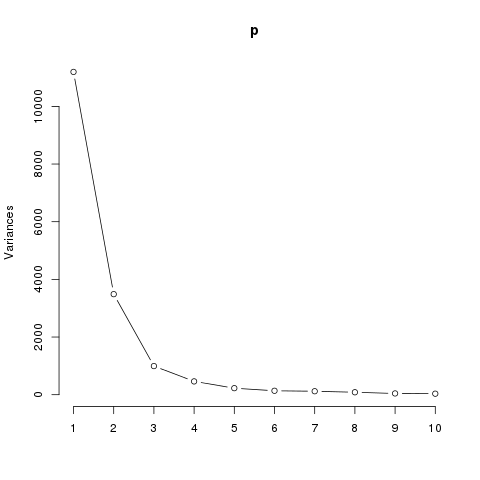

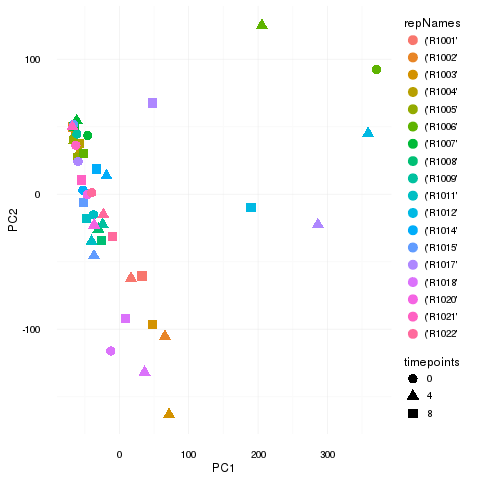

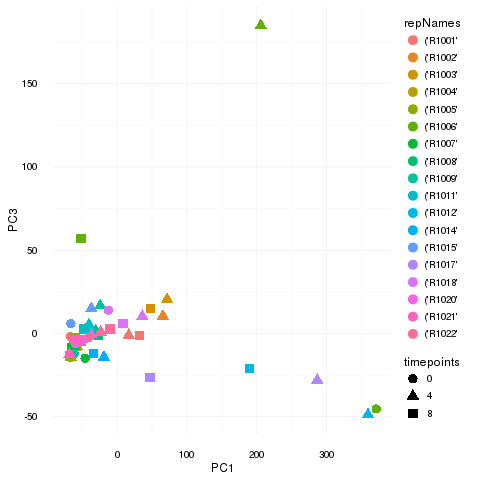

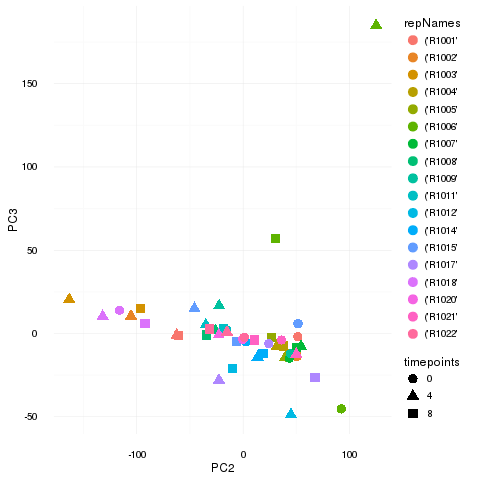

In [95]:
%%R -i df

plotPCA <- function(comps, pca, classes){
        species <- as.factor(unlist(lapply(as.character(classes),FUN=as_species)))
        df <- data.frame(pca$x)
        df['Groups'] = classes
        df['Species'] = species
        combs <- combn(comps,2,simplify=F)
        for (comb in combs){
            X = colnames(df)[comb[1]]
            Y = colnames(df)[comb[2]]
            p <- ggplot(df,aes_string(x=X,y=Y, color="Species",shape="Species")) +
                    geom_point(size=8) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="Species")) +
                    theme_minimal()
            print(p)
        }
    
        ad <- adonis(pca$x[,1:2] ~ Species,data=df,method='bray')

    return(ad)
}

timepoints <- unlist(lapply(rownames(df),FUN=function(el){
                                    el <- strsplit(el,',')[[1]]
                                    return(el[2])
                                    }))
repNames <- unlist(lapply(rownames(df),FUN=function(el){
                                    el <- strsplit(el,',')[[1]]
                                    return(el[1])
                                    }))

df <- df[apply(df, 2, function(col) any(col !=0 ))]
p <- prcomp(df,center=T,scale=F)
plot(p,type='l')
p <- data.frame(p$x[,1:6])
p <- cbind(timepoints,p)
p <- cbind(repNames,p)
#print(p)


p12 <- ggplot(p,aes_string(x='PC1',y='PC2', color="repNames",shape='timepoints')) +
                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

p13 <- ggplot(p,aes_string(x='PC1',y='PC3', color="repNames",shape='timepoints')) +
                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

p23 <- ggplot(p,aes_string(x='PC2',y='PC3', color="repNames",shape='timepoints')) +
                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

print(p12)
print(p13)
print(p23)



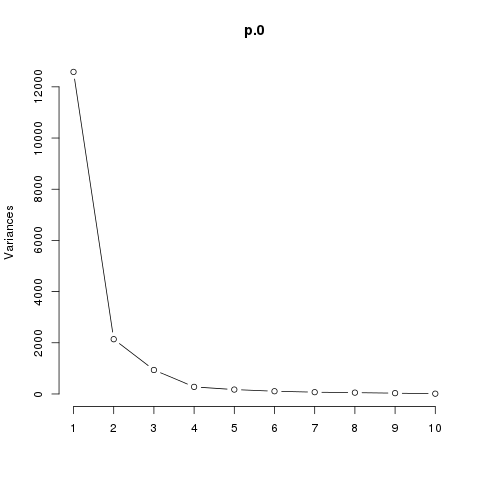

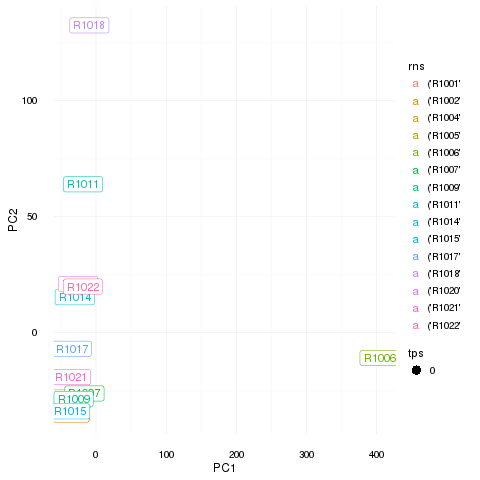

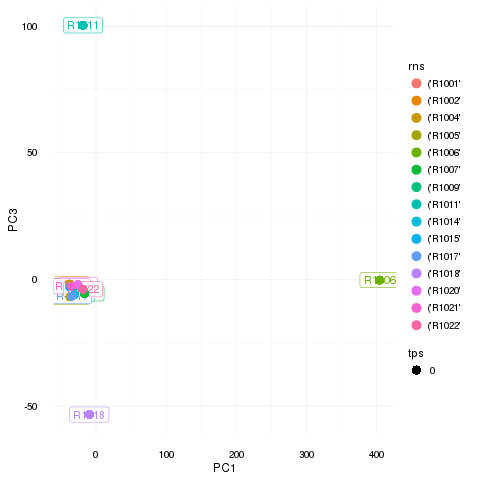

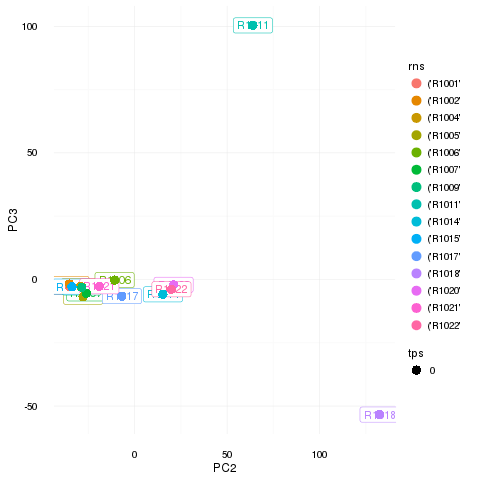

In [108]:
%%R


df.0 <- df[timepoints == ' 0',]
p.0 <- prcomp(df.0,center=T)
plot(p.0,type='l')
p.0 <- data.frame(p.0$x[,1:6])
tps <- timepoints[timepoints == ' 0']
p.0 <- cbind(tps,p.0)
rns <- repNames[timepoints == ' 0']
p.0 <- cbind(rns,p.0)


p12 <- ggplot(p.0,aes_string(x='PC1',y='PC2', color="rns",shape='tps')) +
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+

                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

p13 <- ggplot(p.0,aes_string(x='PC1',y='PC3', color="rns",shape='tps')) +
                    geom_label(aes(label=rownames(p)))+

                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

p23 <- ggplot(p.0,aes_string(x='PC2',y='PC3', color="rns",shape='tps')) +
                    geom_label(aes(label=rownames(p)))+

                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

print(p12)
print(p13)
print(p23)

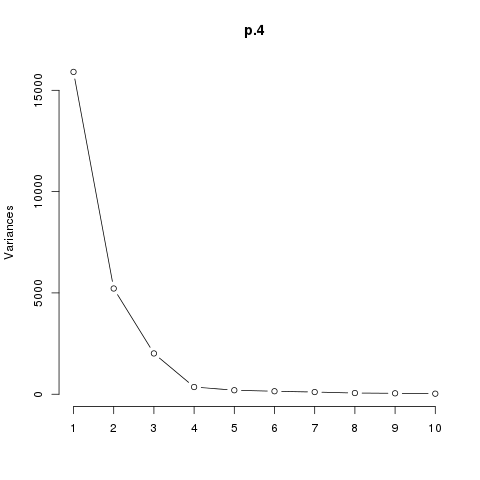

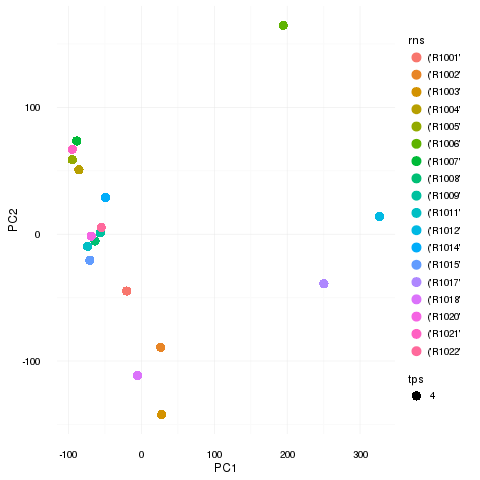

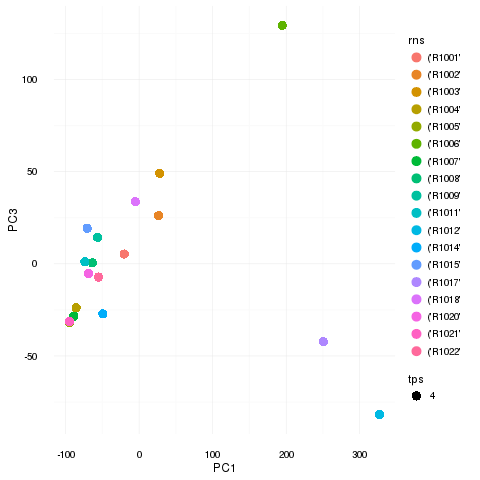

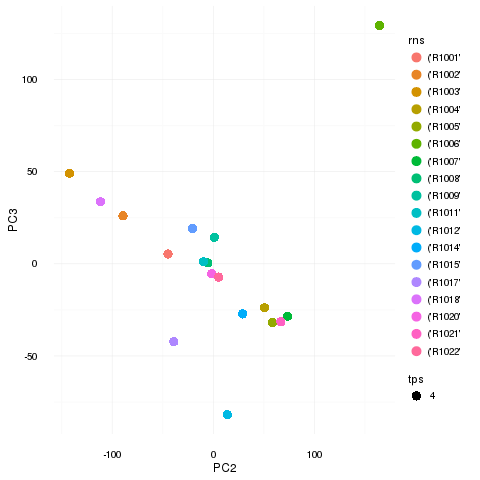

In [12]:
%%R


df.4 <- df[timepoints == ' 4',]
p.4 <- prcomp(df.4,center=T)
plot(p.4,type='l')
p.4 <- data.frame(p.4$x[,1:6])
tps <- timepoints[timepoints == ' 4']
p.4 <- cbind(tps,p.4)
rns <- repNames[timepoints == ' 4']
p.4 <- cbind(rns,p.4)


p12 <- ggplot(p.4,aes_string(x='PC1',y='PC2', color="rns",shape='tps')) +
                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

p13 <- ggplot(p.4,aes_string(x='PC1',y='PC3', color="rns",shape='tps')) +
                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

p23 <- ggplot(p.4,aes_string(x='PC2',y='PC3', color="rns",shape='tps')) +
                    geom_point(size=4) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    #stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="timepoints")) +
                    theme_minimal()

print(p12)
print(p13)
print(p23)








In [13]:
from scipy import stats

ps = {}
for key in pnl.major_axis:
    a = pnl.major_xs(key).dropna(axis=1).transpose()
    p = stats.ttest_rel(a[0],a[4],axis=None,nan_policy='raise').pvalue 
    if not np.isnan(p):
        ps[key] = p
        

ps


{'AAA22905': 0.27686497550676814,
 'AAA98484': 0.23087072223079702,
 'AAB03644': 0.33704905795358431,
 'AAB51122': 0.046135944666236356,
 'AAC41391': 0.33704905795358442,
 'AAD26631': 0.33704905795358442,
 'ABCAntibioticEffluxPump_10': 0.26921277212525152,
 'ABF69686': 0.070976501886225868,
 'ABG36114': 0.65576756174020745,
 'ABN80187': 0.39494999014924681,
 'ABP68837': 0.33704905795358442,
 'ANT3_1': 0.35580112160174626,
 'ANT6_0': 0.33704905795358442,
 'ANT6_1': 0.24380603875889065,
 'APH6_5': 0.37862493045915568,
 'BAA07922': 0.33704905795358442,
 'BAC77251': 0.64539021840356314,
 'CAE48334': 0.83125013430343531,
 'CAG27847': 0.33704905795358442,
 'CAL18627': 0.33704905795358431,
 'CAM12479': 0.35731549123870443,
 'CepA_3': 0.29395063634440821,
 'Cfr23RibosomalRNAMethyltransferase_3': 0.090353421999689015,
 'CfxA_11': 0.042841717292459801,
 'FluoroquinoloneResistantDNATopoisomerase_2': 0.44386059743470396,
 'FluoroquinoloneResistantDNATopoisomerase_28': 0.16699006826820559,
 'Fluoro

In [14]:
%%R -i tbl


tbl <- tbl[,c(3,1,2)]
print(sum(tbl[,2] > tbl[,1]))
print(sum(tbl[,2] < tbl[,1]))
print(sum(tbl[,3] > tbl[,1]))


tblUp <- tbl[tbl[,2] > tbl[,1],]
tblDown <- tbl[tbl[,2] < tbl[,1],]
tblNew <- tbl[(tbl[,2] > 0 | tbl[,3] > 0) & tbl[,1] == 0,]
tblLost <- tbl[tbl[,1] > 0 & tbl[,3] == 0,]

# pseudocount <- 0.001
# tbl <- log(tbl + pseudocount)
# colnames(tbl) <- c(0,4,8)
matplot(t(tblNew),type='l')
matplot(t(tblLost),type='l')


[1] 0
[1] 849
[1] 4
Error in x[, 1L] : subscript out of bounds


In [16]:
pnl

<class 'pandas.core.panel.Panel'>
Dimensions: 18 (items) x 849 (major_axis) x 3 (minor_axis)
Items axis: R1001 to R1022
Major_axis axis: 1112175A to vanY_1
Minor_axis axis: (0, Count) to (8, Count)

In [190]:
pre = pnl.minor_xs(pnl.minor_axis[0])
post = pnl.minor_xs(pnl.minor_axis[1])

rawdelta = post - pre


In [191]:
%%R -i delta

print(dim(delta))

[1] 93 15


In [208]:
%%R -i rawdelta,pre,post -o delta
delta <- rawdelta
delta <- delta[,apply(delta,2,function(c){ 
    s= sum(c)
    if( is.na(s) || s == 0){
        return(FALSE)
        }
    return(TRUE)
})]

delta <- delta[apply(delta,1,function(r){ 
    s= sum(r)
    if( is.na(s) || s == 0){
        return(FALSE)
        }
    return(TRUE)
}),]

sdelta <- t(sign(delta))

inpost <- post > 0
inpre <- pre > 0 
gained <- post & !pre
lost <- !post & pre
gainedorlost <- gained | lost
print(dim(gainedorlost))
print(dim(dcopy))
gl <- gainedorlost*rawdelta
gl <- gl[,apply(gl,2,function(c){ 
    s= sum(c)
    if( is.na(s) || s == 0){
        return(FALSE)
        }
    return(TRUE)
})]

gl <- gl[apply(gl,1,function(r){ 
    s= sum(r)
    if( is.na(s) || s == 0){
        return(FALSE)
        }
    return(TRUE)
}),]
print(dim(gl))

[1] 849  18
[1] 849  18
[1] 89 15


In [226]:
%%R

gl.t <- t(gl)
#print(rownames(gl))
dirs <- apply(sign(gl.t),2,sum)
dirs <- dirs / nrow(gl.t)
dirs <- dirs[rev(order(abs(dirs)))]
print(dirs[abs(dirs) > 0.2])

#print(rownames(gl.t))
a <- c("R1021","R1014","R1007","R1005","R1022","R1020","R1004","R1011","R1018","R1015","R1001","R1006")
dirs <- apply(sign(gl.t[rownames(gl.t) %in% a,]),2,sum)
dirs <- dirs / length(a)

dirs <- dirs[rev(order(abs(dirs)))]
print(dirs[abs(dirs) > 0.1])

# Groups from heatmap of sdelta (see below)
# a <- c("R1006","R1002","R1007","R1009")
# dirs <- apply(sdelta[rownames(sdelta) %in% a,],2,sum)
# dirs <- dirs / length(a)
# dirs <- dirs[rev(order(abs(dirs)))]
# print(dirs[abs(dirs) > 0.7])
# print('------------------')
# b <- c("R1001","R1015","R1017","R1021")
# dirs <- apply(sdelta[rownames(sdelta) %in% b,],2,sum)
# dirs <- dirs / length(b)
# dirs <- dirs[rev(order(abs(dirs)))]
# print(dirs[abs(dirs) > 0.7])



YP_001396002      CfxA_11       P06571 
   0.3333333    0.3333333    0.2666667 
                                               CfxA_11 
                                             0.4166667 
                                             YP_691152 
                                            -0.3333333 
                                                soxR_5 
                                            -0.2500000 
                                             YP_542447 
                                            -0.2500000 
                                             YP_310429 
                                            -0.2500000 
                                          YP_002382193 
                                            -0.2500000 
                                          YP_001480516 
                                            -0.2500000 
                                          YP_001457897 
                                            -0.2500000 
                        

 [1] "R1001" "R1002" "R1004" "R1005" "R1006" "R1007" "R1009" "R1011" "R1014"
[10] "R1015" "R1017" "R1018" "R1020" "R1021" "R1022"


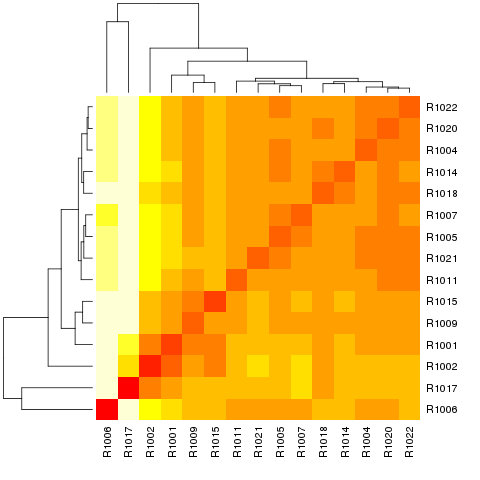

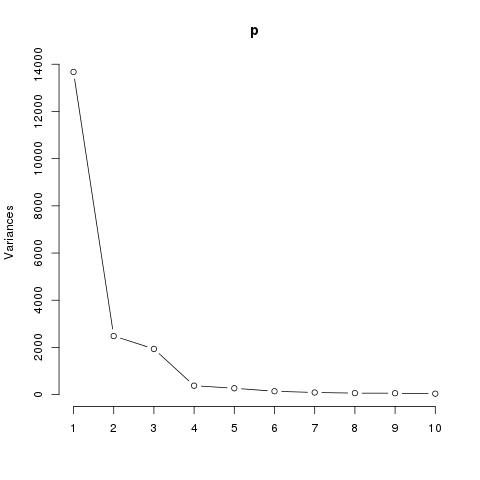

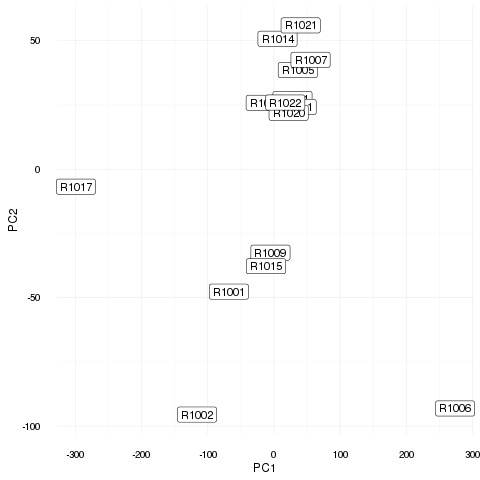

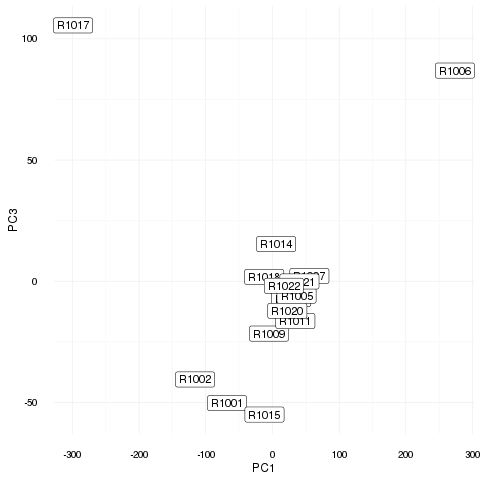

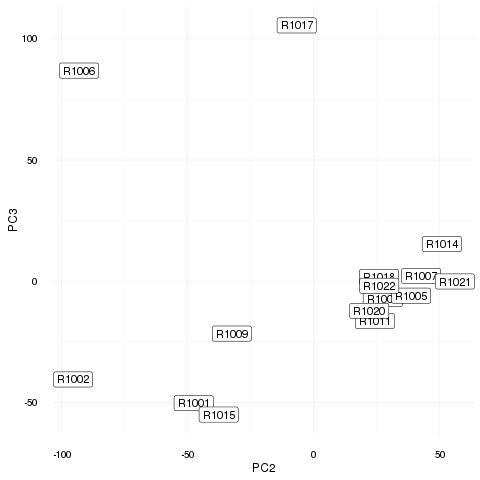

In [111]:
%%R

delta <- t(delta)
d <- dist(delta)
heatmap(as.matrix(d))

p <- prcomp(delta)
plot(p,type='l')
p <- data.frame(p$x[,1:6])

p12 <- ggplot(p,aes_string(x='PC1',y='PC2') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+
                    theme_minimal()
p13 <- ggplot(p,aes_string(x='PC1',y='PC3') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+
                    theme_minimal()
p23 <- ggplot(p,aes_string(x='PC2',y='PC3') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+
                    theme_minimal()
print(rownames(delta))
print(p12)
print(p13)
print(p23)



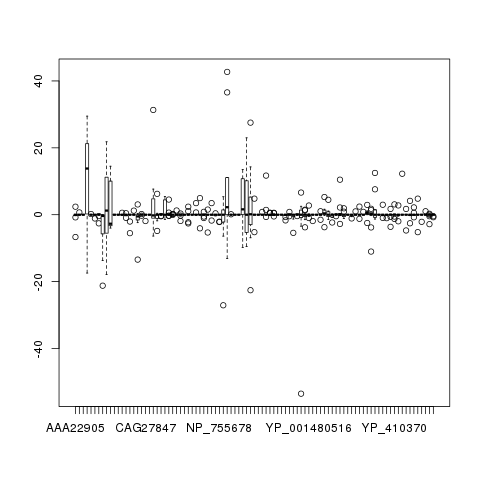

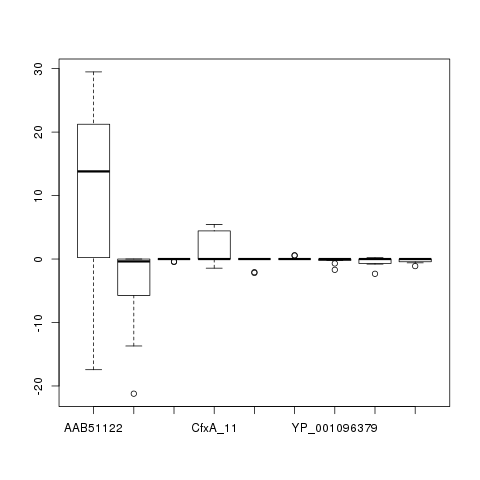

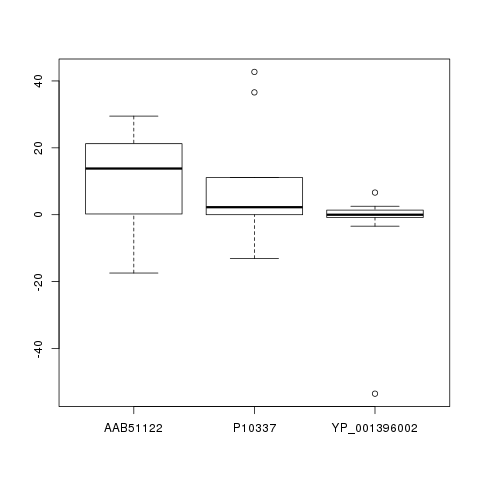

In [141]:
%%R -i pre,post,delta

a = c("R1021","R1014","R1007","R1005","R1022","R1020","R1004","R1011","R1018")
b = c("R1009","R1015","R1001")
da <-  t(delta[,colnames(delta) %in% a])
boxplot(da)
cov <- function(a){
    sd(a)/mean(a)
}
covs <- apply(da,2,cov)
covs <- covs[abs(covs)<2]

means <- apply(da,2,mean)
#print(means[rev(order(abs(means)))])
means <- means[abs(means) > 5]
boxplot(da[,colnames(da) %in% names(covs)])
boxplot(da[,colnames(da) %in% names(means)])

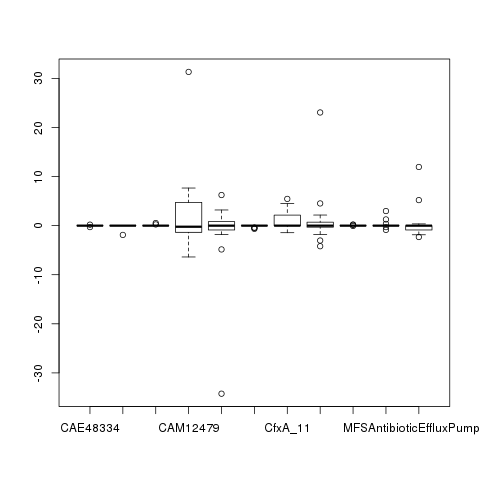

In [65]:
%%R -i delta,cov

delta <- delta[abs(as.numeric(cov)) < 3,]

boxplot(t(delta))









In [219]:
%%R


UsageError: %%R is a cell magic, but the cell body is empty. Did you mean the line magic %R (single %)?

$correction
[1] "none" "1"   

$note
[1] "No correction was applied to the negative eigenvalues"

$values
     Eigenvalues  Relative_eig Rel_corr_eig Broken_stick Cum_corr_eig
1   522466.30048  6.214709e-01   0.26751720   0.24462567    0.2675172
2   190068.05286  2.260849e-01   0.12656316   0.16770260    0.3940804
3   145506.85698  1.730796e-01   0.10766691   0.12924106    0.5017473
4    55497.34735  6.601380e-02   0.06949822   0.10360003    0.5712455
5    22109.52230  2.629916e-02   0.05534005   0.08436926    0.6265855
6     6173.47108  7.343311e-03   0.04858234   0.06898465    0.6751679
7     2635.22338  3.134584e-03   0.04708194   0.05616414    0.7222498
8     2263.19640  2.692060e-03   0.04692419   0.04517512    0.7691740
9     1788.39073  2.127281e-03   0.04672284   0.03555974    0.8158969
10     375.03940  4.461074e-04   0.04612351   0.02701273    0.8620204
11     134.29803  1.597468e-04   0.04602142   0.01932042    0.9080418
12      48.72874  5.796257e-05   0.04598514   0.012327

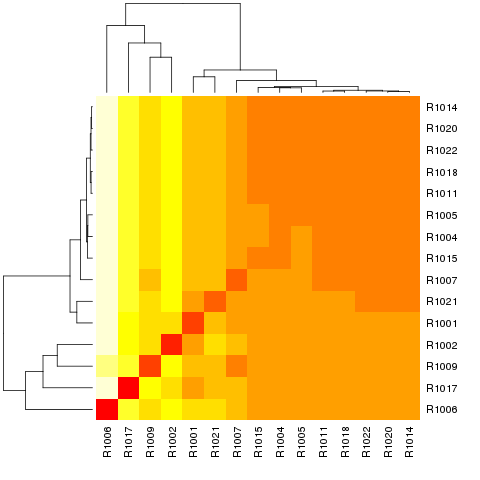

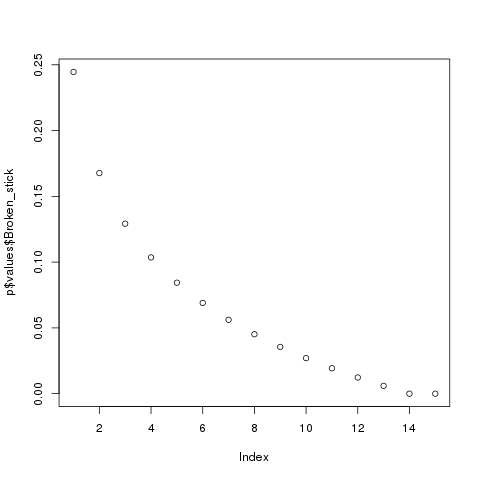

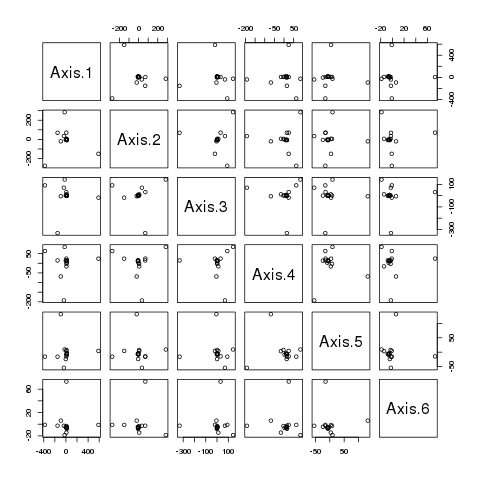

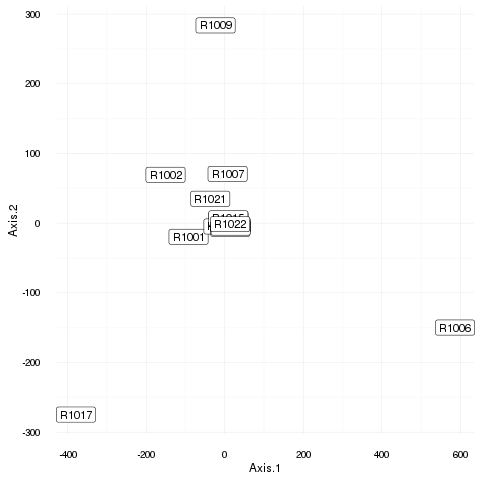

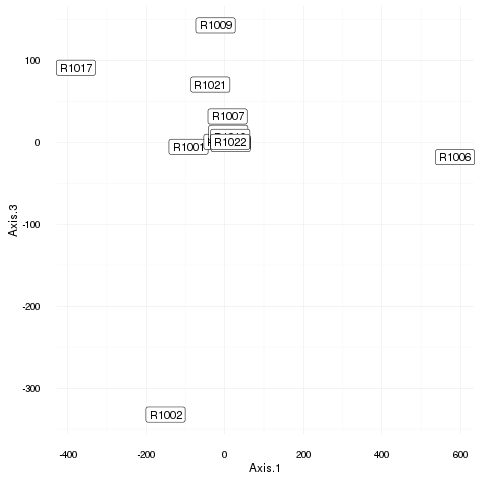

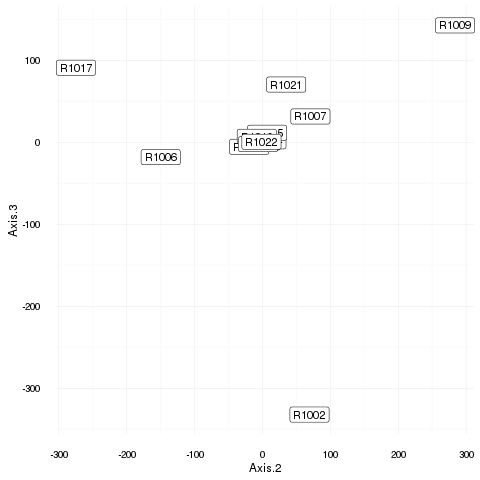

In [220]:
%%R
library(ape)


d <- dist(gl.t,method='manhattan')
heatmap(as.matrix(d))
p <- pcoa(d)
print(p)
plot(p$values$Broken_stick)

pairs(p$vectors[,1:6])


p <- data.frame(p$vectors[,1:6])

p12 <- ggplot(p,aes_string(x='Axis.1',y='Axis.2') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+
                    theme_minimal()
p13 <- ggplot(p,aes_string(x='Axis.1',y='Axis.3') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+

                    theme_minimal()
p23 <- ggplot(p,aes_string(x='Axis.2',y='Axis.3') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+

                    theme_minimal()
print(p12)
print(p13)
print(p23)



$correction
[1] "none" "1"   

$note
[1] "No correction was applied to the negative eigenvalues"

$values
   Eigenvalues Relative_eig Rel_corr_eig Broken_stick Cum_corr_eig
1   12392.6481  0.499773415  0.376284466   0.24462567    0.3762845
2    3612.7075  0.145694054  0.124283813   0.16770260    0.5005683
3    2916.9978  0.117637321  0.104315648   0.12924106    0.6048839
4    2495.2718  0.100629865  0.092211328   0.10360003    0.6970953
5    1630.6696  0.065762001  0.067395635   0.08436926    0.7644909
6     911.4823  0.036758456  0.046753618   0.06898465    0.8112445
7     899.8106  0.036287760  0.046418620   0.05616414    0.8576631
8     572.0179  0.023068462  0.037010357   0.04517512    0.8946735
9     421.7984  0.017010376  0.032698777   0.03555974    0.9273723
10    211.5291  0.008530593  0.026663659   0.02701273    0.9540359
11    144.4975  0.005827325  0.024739725   0.01932042    0.9787756
12      0.0000  0.000000000  0.017184129   0.01232742    0.9959598
13   -118.7466 -0.00478

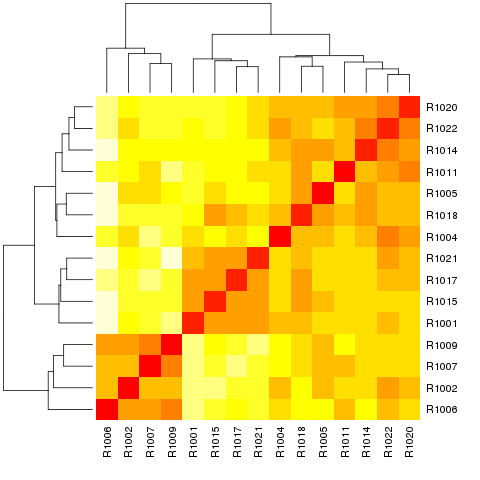

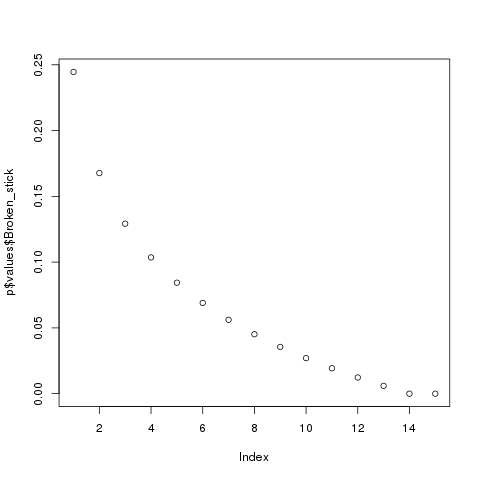

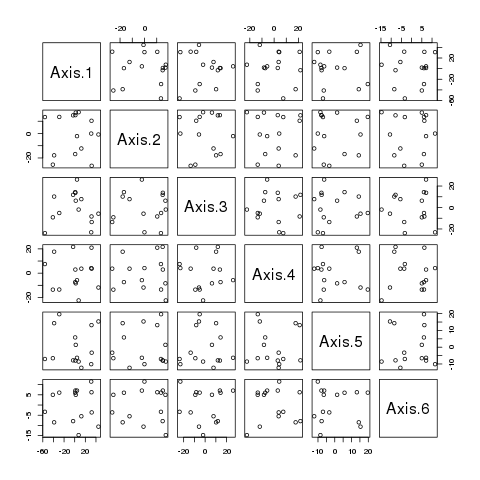

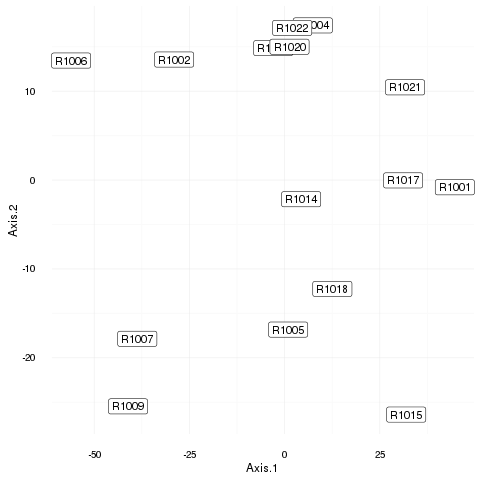

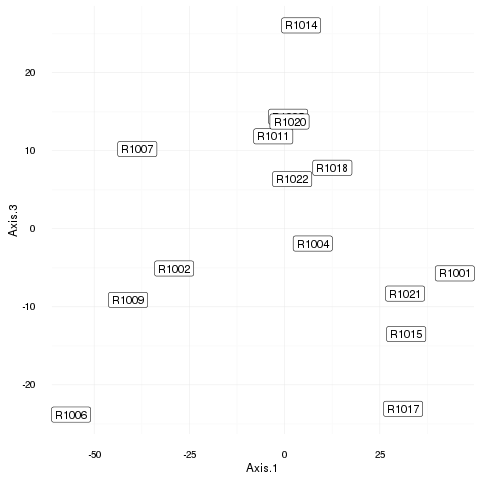

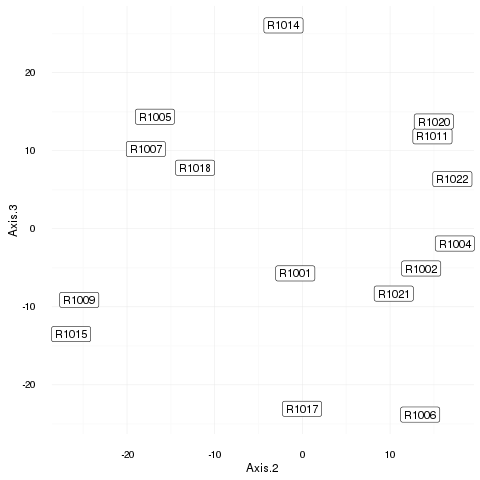

In [109]:
%%R
library(ape)


d <- dist(sdelta,method='manhattan')
heatmap(as.matrix(d))
p <- pcoa(d)
print(p)
plot(p$values$Broken_stick)

pairs(p$vectors[,1:6])


p <- data.frame(p$vectors[,1:6])

p12 <- ggplot(p,aes_string(x='Axis.1',y='Axis.2') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+
                    theme_minimal()
p13 <- ggplot(p,aes_string(x='Axis.1',y='Axis.3') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+

                    theme_minimal()
p23 <- ggplot(p,aes_string(x='Axis.2',y='Axis.3') )+
                    geom_point(size=4) +
                    geom_label(aes(label=rownames(p)))+

                    theme_minimal()
print(p12)
print(p13)
print(p23)



In [125]:
import pandas as pd
from glob import glob
import numpy as np

samplelist = pd.read_table('../crohns.samplelist.edited.csv',header=0,index_col=0)
mp2s = glob('../metaphlan2/crohns/*results.txt')
mp2Pnl = {}

for mp2 in mp2s:
    srr = mp2.split('/')[-1]
    srr = srr.split('.')[0]
    sid = samplelist['subject id'][srr].strip()
    if sid not in mp2Pnl:
        mp2Pnl[sid] = {}
    tpt = samplelist['time point'][srr].strip()
    mp2Res = pd.Series.from_csv(mp2,sep='\t')
    mp2Pnl[sid][tpt] = mp2Res 

mp2Pnl = pd.Panel(mp2Pnl)
print(mp2Pnl.shape)
mp2Pnl = mp2Pnl.filter(regex='.g__\w+$',axis=1)
taxaw4 = mp2Pnl.minor_xs(mp2Pnl.minor_axis[1])
taxaw4 = taxaw4.dropna(axis=1,how='all').dropna(axis=0,how='all')
pd.write_table(taxaw4,path='foo')

(22, 788, 4)


AttributeError: 'module' object has no attribute 'write_table'

In [122]:
taxaw4

,R1001,R1002,R1003,R1004,R1005,R1006,R1007,R1008,R1011,R1012,R1014,R1015,R1017,R1018,R1021,R1022
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,NaN,NaN,NaN,0.3496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia,NaN,0.04527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00572
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacteriaceae_unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02097,NaN,NaN,NaN,NaN
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium,NaN,NaN,0.0161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,1.16272,NaN,0.07168,0.19728,1.07021,0.38566,0.16268,0.07103,0.23067,0.61957,0.01963,0.1399,3.36476,0.33667,2.56068,0.00265
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia,NaN,NaN,NaN,0.00193,0.05376,NaN,NaN,NaN,NaN,NaN,NaN,0.18528,NaN,NaN,NaN,NaN
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,0.0275,NaN,0.00445,0.05051,NaN,0.5802,NaN,0.02312,0.03784,NaN,NaN,0.00168,NaN,0.37168,NaN,0.01766
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella,NaN,NaN,0.00133,NaN,0.16866,NaN,NaN,NaN,NaN,0.14067,0.08876,0.00489,0.50726,0.0012,NaN,NaN
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,55.94503,NaN,55.80179,15.96705,15.76433,19.1551,45.83064,58.09026,50.4393,34.02151,63.36001,50.05849,4.96038,42.65032,19.47037,0.81827
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname,NaN,NaN,NaN,0.87572,NaN,1.28348,NaN,NaN,0.21685,0.32467,0.10895,NaN,NaN,NaN,NaN,NaN


In [123]:
%%R -i taxaw4

#w4 <- apply(w4,1:2,ifelse(is.na(el),0,el))
print(dim(taxaw4))

p <- prcomp(w4,center=T,scale=T)

plot(p,type='l')
p <- data.frame(p$x[,1:6])
# p <- cbind(timepoints,p)
# p <- cbind(repNames,p)
#print(p)


p12 <- ggplot(p,aes_string(x='PC1',y='PC2')) +
                    geom_point(size=4) +
                    theme_minimal()



[1]    1 1360
Error in colMeans(x, na.rm = TRUE) : 'x' must be numeric
